# *A comparison of methods for structural learning of Bayesian networks from data*

## Machine Learning and Neural Networks
## David Revillas and Jon Ander González

Bayesian networks (BNs) are probabilistic graphical models that serve to represent probabilistic dependencies between variables in uncertain domains. The implementation of methods for learning and in-
ferring these graphical models from data is not straightforward and can be computationally costly.

The aim of the project is to compare 2 different learning methods: **Score-based Structure Learning** and **Constrain Based Structure Learning**. Given a dataset of binary vectors, the programa will output the Bayesian Network learnt from data, also visualizating it. For the Score-based Structure Learning, the data is discrete, as a challenge.

For more information, the repository is at [BitBucket server](https://bitbucket.org/davidr3v1/mlnn-project-1/src/master/).

### Requirements

Just run the following command `pip install --user numpy pandas graphviz requests` on your system or virtual environment.

*Note: virtual environment is recommended to keep safe your system and to not corrupt any library on it.*

In [ ]:
!pip install --user numpy pandas graphviz requests networkx

### Imports

Import minimum tools for array manipulation, graph visualization and numeric calculations.

In [1]:
import math
import logging
import time
from copy import deepcopy
from itertools import permutations, combinations

import numpy
import pandas

# Compute number of combinations nCr
from scipy.special import comb 

#Chi2 test
from scipy.stats import chi2_contingency, chi2

# Visualization stuff
import graphviz
from graphviz import Digraph


from IPython.display import display
import logging

#For Constrain-base structure learning
import networkx as nx

### Math functions
Let's start defining some probability computations methods: probability and conditional probability on a random variable

In [2]:
def proba(x, v, data):
    """
    Returns the probability of variable x in the dataset of taking value v.

    Parameters
    --------
    x: str
        data column index
    v: int, str
        value of x
    data: pandas DataFrame
        Dataset
    """
    assert type(data) == pandas.DataFrame, "Dataset is not a pandas DataFrame"

    col = data[x]
    if v in col.value_counts() and len(col):
        proba = col.value_counts()[v] / len(col)
    else:
        proba = 0

    return proba


def proba_cond(x, v, parents, data):
    """
    Returns the probability of a variable x taking value v conditioned by its parents taking
    another values.

    Parameters
    --------
    data: pandas dataframe
    x: str
        data column index
    v: int, str
        value of x
    parents: list of tuples
        List of tuples (n, v), where n indicates parent's name
        and v parent's value
    data: pandas DataFrame
        Dataset
    """
    assert type(data) == pandas.DataFrame, "Dataset is not a pandas DataFrame"

    query = " and ".join([f"{pa_x} == {pa_v}" for (pa_x, pa_v) in parents])

    queried = data.query(query)
    counts = queried[x].value_counts()
    if v in counts and len(queried):
        proba_conda = counts[v] / len(queried)
    else:
        proba_conda = 0

    return proba_conda


## Score-based Structure Learning

### 1) Score metrics

There exist many score metrics available. We decide to use the Minimum Description Length (MDL), which  aims 
to minimize the space used to store a model and the data to be encoded in the model \[[1](#References)\]. 

#### Minimum Description Length (MDL)
In the case of learning Bayesian network $B$ which is composed of a graph $G$ and the associated conditional probabilities $P_B$, the MDL criterion requires choosing a network that minimizes the total description length of the network structure and the encoded data, which implies that the learning procedure balances the complexity of the induced network with the degree of accuracy with which the network represents the data. 

The MDL metric is computed as:

$MDL(G : D) = DL_{graph}(G) + \sum_i DL_{tab}(x_i) + DL_{data}(D|B)$


##### Graph Description Length
Since the number of parents $|\pi(i)|$ can be encoded in $\log n$ bits, and the indices of all parents of node $i$ can be encoded in $\log(\binom{n}{\pi(i)})$  bits, the description length of the graph structure $G$ is:

$DL_{graph}(G) = \sum\limits_{i}(\log n + \log (\binom{n}{|\pi(i)|}))$

where $\pi(i)$ represents the set of parents of variable $x_i$.

##### CPD Description Length
The number of parameters used for the table associated with $x_i$ is $|\pi(i)|(|x_i|−1)$. The description length of these parameters depends on the number of bits used for each numeric parameter. A usual choice is $\frac{1}{2} \log N$ . So the description length for $x_i$’s CPD is:

$DL_{tab}(x_i) = \frac{1}{2} * |\pi(i)|(|x_i|−1) \log N$

##### Data Description Length
The formula provides an information-theoretic interpretation to the representation of the data. It measures how many bits are necessary to encode the values of $x_i$ once we know $x_{\pi(i)}$.

$DL_{data}(D|B) = - \sum\limits_i \sum\limits_{x_i, x_{\pi(i)}} \#(x_i, x_{\pi(i)}) \log P(x_i|x_{\pi(i)})$

where $(x_i, x_{\pi(i)})$ is a local configuration of variable $x_i$ and its parents, $\#(x_i, x_{\pi(i)})$ is the number of the occurrence of this configurationin the training data.

### Implementation notes

Minimum Description Length implementation done by David Revillas, using object oriented programming and some dynamic programming features to speed up the execution almost 10 times. Created every method from scratch, taking as reference Chapter 3.1 from \[[1](#References)\].

In [3]:
class MDL:
    def __init__(self, data):
        assert type(data) == pandas.DataFrame
        self.data = data

        self.epsilon = 0

        # Dynamic programming
        self._times_in_ds = {}
        self._combinations = {}
        self._proba = {}
        self._proba_cond = {}
        self._occurrences = {}

    def proba(self, x, v):
        """
        Returns the probability of variable x in the dataset of taking value v.

        Parameters
        --------
        x: str
            data column index
        v: int, str?
            value of x
        """
        if (x, v) not in self._proba:
            col = self.data[x]
            if v in col.value_counts() and len(col):
                self._proba[(x, v)] = col.value_counts()[v] / len(col)
            else:
                self._proba[(x, v)] = self.epsilon

        return self._proba[(x, v)]

    def proba_cond(self, x, v, parents):
        """
        Returns the probability of a variable x taking value v conditioned by its parents taking
        another values.

        Parameters
        --------
        data: pandas dataframe
        x: str
            data column index
        v: int, str?
            value of x
        parents: list of tuples
            List of tuples (n, v), where n indicates parent's name
            and v parent's value

        Examples
        --------
        >>> parents = [("B", 0), ("A", 1)]
        """
        query = " and ".join([f"{pa_x} == {pa_v}" for (pa_x, pa_v) in parents])

        if (x, v, query) not in self._proba_cond:
            queried = self.data.query(query)
            counts = queried[x].value_counts()
            if v in counts and len(queried):
                self._proba_cond[(x, v, query)] = counts[v] / len(queried)
            else:
                self._proba_cond[(x, v, query)] = self.epsilon

        return self._proba_cond[(x, v, query)]

    @staticmethod
    def dl_graph(model):
        """
        Computes Description Length of the graph.

        Since the number of parents :math:`|\pi(i)|` can be encoded in :math:`\log n` bits, and the
        indices of all parents of node `i` can be encoded in :math:`\log(n \pi(i))`  bits, the description
        length of the graph structure `G` is [1]_:

        .. math:: DL_{GRAPH}(G) = \sum_{i}(\log n + \log ( \\binom{n}{|\pi(i)|} ))

        Parameters
        ---------
        model: dict, Model
            Model structure

        Returns
        -------
        int
            Description Length score of graph `G`.

        References
        ---------
        .. [1] Y. Zhou, Structure Learning of Probabilistic Graphical Models:  A Comprehensive Survey,
            Chapter 3.1.1, equation 3.1, https://arxiv.org/pdf/1111.6925.pdf

        See also
        --------
        - Scipy Comb: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.comb.html

        Examples
        ------
        >>> df = pandas.DataFrame([[0, 0, 1], [1, 0, 0], [0, 0, 1], [1, 1, 0], [0, 1, 0], [1, 1, 1]], columns=list("ABC"))
        >>> mdl = MDL(df)
        >>> model = Model({"A":{"B", "C"}, "B":{"C"}, "C":{})
        >>> mdl.dl_graph(model)
        5.493061443340549
        """
        assert type(model) in [dict, Model], "Model should be passed as dict or Model instance"
        if type(model) is dict:
            model = Model(model)

        # Number of variables in the model
        n = len(model.nodes)

        s = 0
        for (_, pa) in model.parents.items():
            s += math.log(n) + math.log(comb(n, len(pa)))

        return s

    def dl_tab(self, model, x):
        """
        Computes Description Length over the CPD table.

        The number of parameters used for the table associated with `x_i` is
        :math:`|\\pi(i)|(|x_i|−1)`. The description length of these parameters depends on
        the number of bits used for each numeric parameter. A usual choice is `1/2 logN` .
        So the description length for :`x_i`’s CPD is:

        .. math:: DL_{TAB}(x_i) = 0.5 * |\\pi(i)|(|x_i|−1) \\log N

        Parameters
        ---------
        model: dict, Model
            Model structure
        x: str
            Variable name

        Returns
        -------
        int
            Description Length score of `x_i` CPD.

        References
        ---------
        .. [1] Y. Zhou, Structure Learning of Probabilistic Graphical Models:  A Comprehensive Survey,
            Chapter 3.1.1, https://arxiv.org/pdf/1111.6925.pdf
        """
        assert type(model) in [dict, Model], "Model should be passed as dict or Model instance"
        if type(model) is dict:
            model = Model(model)

        return 0.5 * len(model.parents[x]) * (len(self.data[x].value_counts().keys()) - 1) * math.log(
            len(self.data))

    def _times_in_dataset(self, x, val, pa, pa_values):
        """
        Counts the number of times the combinations (x=val, pa=pa_values)
        appears in the dataset.

        Parameters
        ---------
        x: str
            Variable name in dataset
        val: int, float
            Variable value
        pa: tuple
            Parent's names in dataset
        pa_values: list
            Parent's values

        Returns
        -------
        int
            Occurrences of given combination

        References
        ---------
        - Pandas Query, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html
        """
        query = f"{x} == {val} and "
        query += " and ".join([f"{pa[i]} == {pa_values[i]}" for i in range(len(pa))])

        if query not in self._times_in_ds:
            queried = self.data.query(query)
            self._times_in_ds[query] = len(queried)

        return self._times_in_ds[query]

    def _combinations_of_parents_values(self, parents):
        """
        Generates all possible combinations of parent's values, taking
        into account that parents may not have same values.

        Parameters
        ----------
        parents: tuple
            Parent's variable names in the dataset

        Returns
        -------
        ndarray
            Combinations of values

        References
        --------
        - NumPy Tile: https://docs.scipy.org/doc/numpy/reference/generated/numpy.tile.html
        - NumPy Repeat: https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html
        """

        if parents not in self._combinations:
            values = {p: list(self.data[p].value_counts().keys()) for p in parents}
            i = 0
            num_combinations = numpy.product([len(v) for v in values.values()])
            combinations = numpy.zeros((num_combinations, len(values.keys())))
            r = 1
            while i < len(values.keys()):
                parent = list(values.keys())[i]
                l = numpy.tile(numpy.repeat(values[parent], r), num_combinations // len(values[parent]))
                combinations[:, i] = l[:num_combinations]
                r *= len(values[parent])
                i += 1

            self._combinations[parents] = combinations

        return self._combinations[parents]

    def dl_data(self, model):
        """
        Computes the Description Length over the train data.

        The formula [1]_ provides an information-theoretic interpretation to the representation of the data:
        it measures how many bits are necessary to encode the values ofxionce we know `xπ(i)`.

        Parameters
        ---------
        model: dict, Model
            Model structure

        Returns
        -------
        int
            Description Length score of dataset

        References
        ---------
        .. [1] Y. Zhou, Structure Learning of Probabilistic Graphical Models:  A Comprehensive Survey,
            Chapter 3.1.1, https://arxiv.org/pdf/1111.6925.pdf
        """
        assert type(model) in [dict, Model], "Model should be passed as dict or Model instance"
        if type(model) is dict:
            model = Model(model)

        s = 0
        for x in model.nodes:
            x_values = list(self.data[x].value_counts().keys())
            pa = tuple(model.parents[x])

            if pa:
                pa_values = self._combinations_of_parents_values(pa)
                for x_value in x_values:
                    for pa_value in pa_values:
                        occurences = self._times_in_dataset(x, x_value, pa, pa_value)

                        if occurences:
                            prob_cond = self.proba_cond(x, x_value, zip(pa, pa_value))
                            s += occurences * math.log(prob_cond)

            else:
                for x_value in x_values:
                    if (x, x_value) not in self._occurrences:
                        self._occurrences[(x, x_value)] = self.data[x].value_counts()[x_value]

                    prob = self.proba(x, x_value)

                    s += self._occurrences[(x, x_value)] * math.log(prob)

        s *= -1

        return s

    def score(self, model):
        """
        Computes the full Minimum Description Length score.

        Parameters
        ---------
        model: dict, Model
            Model structure

        Returns
        -------
        int
            Description Length score of graph `G` and data `D`.

        References
        ---------
        .. [1] Y. Zhou, Structure Learning of Probabilistic Graphical Models:  A Comprehensive Survey,
            Chapter 3.1.1, equation 3.2, https://arxiv.org/pdf/1111.6925.pdf
        """
        assert type(model) in [dict, Model], "Model should be passed as dict or Model instance"
        if type(model) is dict:
            model = Model(model)

        dl_graph = self.dl_graph(model)
        dl_tab = sum([self.dl_tab(model, x) for x in model.nodes])
        dl_data = self.dl_data(model)

        return dl_graph + dl_tab + dl_data

### 2) Search methods
1. For this type of learning, we start by generating an initial graph $G$. Despite of being possible using
another search algorithms, we use Hill Climb method. If you are familiar with it, you will know
that it belongs to the family of local search techniques and thus, selecting an appropriate initial state
is important if we want to reach the global optimum. Well, we don't take that into account. 

2. Then, we assign $G' = G$.
3. Compute all possible directed acyclic graphs (DAG) set $Neighbors$ from $G'$, adding, removing or reversing 
an edge in $G$.
4. Choose the best *neighbor*, the one with the highest score and assign it to $G'$
5. Go to 2 an repeat until it converges.

### Implementation notes

Hill Climb Search implementation done by David Revillas, using object oriented programming. Created every method from scratch, taking as reference Chapter 3.2 from \[[1](#References)\].

In [4]:
class HillClimbing:
    def __init__(self, max_iter=100, level=logging.INFO):
        """
        Hill Climbing search method implementation.

        Parameters
        ----------
        max_iter: int
            Maximum iterations

        References
        ---------
        - Articial Intelligence: A Modern Approach, Russel & Norvig (2nd ed.)
        - Structure Learning of Probabilistic Graphical Models:  A Comprehensive Survey,  Y. Zhou, Chapter 3.2, https://arxiv.org/pdf/1111.6925.pdf
        """
        self.epsilon = 10e-10
        self.blocked_states = []
        self.max_iter = max_iter

        logging.basicConfig(format='%(message)s', level=level)

    def neighbors(self, model):
        """
        Returns
        -------
        list
            list of Model instances
        """
        combs = list(permutations(model.nodes, 2))
        self.blocked_states.append(model)

        # Add edges
        added = []
        for (o, d) in combs:
            m = model.copy()
            m.add_edge(o, d)
            added.append(m)

        # Remove edges
        removed = []
        for (o, d) in combs:
            m = model.copy()
            m.remove_edge(o, d)
            if m not in self.blocked_states:
                removed.append(m)

        # Reversed edges
        reverse = []
        for (o, d) in combs:
            m = model.copy()
            m.reverse_edge(o, d)
            if m not in self.blocked_states:
                reverse.append(m)

        neighbors = added + removed + reverse

        return neighbors

    def search(self, data, save=False):
        """
        Parameters
        ----------
        data: pandas.Dataframe
            Dataset
        save: bool
            Save the intermediate models

        References
        ----------
        - Structure Learning of Probabilistic Graphical Models:  A Comprehensive Survey,  Y. Zhou, Algorithm 5, https://arxiv.org/pdf/1111.6925.pdf
        """
        t = time.time()
        assert type(data) == pandas.DataFrame, "Dataset is not a pandas DataFrame"

        # Define a score metric
        metric = MDL(data)

        # Initialize a structure G'
        final = Model({node: set() for node in data.keys()})
        final.plot("model_0")
        logging.info(f"Starting Hill Climb algorithm, {len(final.nodes)} variables detected")
        logging.info("Initializing empty model.")

        converged = False
        last_score = -float('inf')
        i = 0
        while not converged and i < self.max_iter:
            model = final.copy()
            logging.info(f"[iter:{i}] Computing neighbors.")
            neighbors = self.neighbors(model)

            logging.info(f"[iter:{i}] Computing scores")
            scores = numpy.array([metric.score(n) for n in neighbors])
            best_index = int(numpy.argmax(scores))

            score = scores[best_index]
            final = neighbors[best_index].copy()
            logging.info(f"[iter:{i}] Best score: {score}")

            # Check convergence
            if abs(last_score - score) >= self.epsilon:
                last_score = score
            else:
                converged = True

            i += 1

            # Plot graph
            if save:
                final.plot(f"model_{i}")

        final.plot("local_best")
        logging.info(f"Hill Climb took {round(time.time() - t, 3)}s and {i} iterations.")
        return final


### Model container

As we are working with object oriented programming, we need to store the model as an object. We could use the python powerfull library [Networkx](https://networkx.github.io/), but for the Score Based implementation, instead of that, we prefer to implementing it from scratch. It has the next features:

- Check for cycles in $O(V + E)$: since we need to work with DAG's, there must not be any cycles in the graph.
- Adding, removing or reversing edges.
- Copy model, taking into account python copy-by-reference.
- Saving the model visualizatin as *png*. It **requires** a backend like [Graphviz](https://graphviz.gitlab.io/download/).

### Implementation notes

Graph network implementation done by David Revillas, using object oriented programming. Created every method from scratch, except *is_cyclic*.

In [5]:
from copy import deepcopy

import graphviz
import numpy
from graphviz import Digraph


class Model:
    def __init__(self, graph):
        """
        Graph network implementation

        Parameters
        ---------
        graph: python dict
            A dictionary containing the graph, where keys are nodes
            and values are a list containing children nodes.

        Examples
        --------
        >>> model = Model({"A": {"C"}, "B": {"C"}, "C": {}})  # B -> C <- A
        >>> model = Model({"A": {"B", "C"}})  # B <- A -> C
        """
        g = graph.copy()
        for (v, e) in g.items():
            for edge in e:
                if edge not in g.keys():
                    graph[edge] = set()

        # Check if is cyclic
        assert not Model.is_cyclic(graph), "The graph must not contain cycles"

        self.nodes = graph.keys()
        self.children = graph
        self.parents = Model._parents(graph)

        self._node_configs = {}
        self._parents_combinations = {}

    def __str__(self):
        return str(self.children)

    def __repr__(self):
        return str(self.children)

    def __eq__(self, other):
        return other.children == self.children

    def __copy__(self):
        model_copy = Model(deepcopy(self.children))
        return model_copy

    @staticmethod
    def is_cyclic(graph):
        """
        Return True if the directed graph has a cycle.
        The graph must be represented as a dictionary mapping vertices to
        iterables of neighbouring vertices.

        Runtime of O(V + E)

        References
        ----------
        - https://codereview.stackexchange.com/a/86067

        Examples
        --------
        >>> is_cyclic({1: {2}, 2: {3}, 3: {1,}})
        True
        >>> is_cyclic({1: {2}, 2: {3}, 3: {4,}})
        False
        """
        assert type(graph) == dict, "Graph must be dict type"

        visited = set()
        path = [object()]
        path_set = set(path)
        stack = [iter(graph)]
        while stack:
            for v in stack[-1]:
                if v in path_set:
                    return True
                elif v not in visited:
                    visited.add(v)
                    path.append(v)
                    path_set.add(v)
                    stack.append(iter(graph.get(v, ())))
                    break
            else:
                path_set.remove(path.pop())
                stack.pop()
        return False

    @staticmethod
    def _parents(g):
        """
        Returns parents of each node

        Parameters
        --------
        g: python dict
            A dictionary representing the graph.

        Returns
        -------
        dict

        Examples
        -------
        >>> model = Model({"A": {"C"}, "B": {"C"}, "C": {}})  # B -> C <- A
        >>> model.parents
        {"A": set(), "B": set(), "C": {"A", "B"}}
        """
        parents = {k: set() for k in g.keys()}
        for (node, children) in g.items():
            for child in children:
                parents[child].add(node)

        return parents

    def add_edge(self, o, d):
        """
        Adds an edge between nodes `o` and `d`

        Parameters
        ----------
        o, d: str
            Node name
        """
        if o in self.children.keys() and d in self.nodes:
            self.children[o].add(d)
            self.parents[d].add(o)

            # Check for cycle
            if Model.is_cyclic(self.children):
                self.children[o].remove(d)
                self.parents[d].remove(o)

    def remove_edge(self, o, d):
        """
        Removes an existing edge between nodes `o` and `d`

        Parameters
        ----------
        o, d: str
            Node name
        """
        if o in self.nodes and d in self.parents.keys():
            if d in self.children[o]:
                self.children[o].remove(d)
                self.parents[d].remove(o)

                # Check for cycle
                if Model.is_cyclic(self.children):
                    self.children[o].remove(d)
                    self.parents[d].remove(o)

    def reverse_edge(self, o, d):
        """
        Removes an existing edge between nodes `o` and `d`

        Parameters
        ----------
        o, d: str
            Node name
        """
        if o in self.nodes and d in self.parents.keys():
            if d in self.children[o]:
                self.remove_edge(o, d)
                self.add_edge(d, o)

    def copy(self):
        return self.__copy__()

    def plot(self, fig_name):
        """Plots the model"""
        try:
            dot = Digraph()
            for n in self.nodes:
                dot.node(n, n)

            for (parent, children) in self.children.items():
                for child in children:
                    dot.edge(parent, child)

            # For saving png
            # dot.render(fig_name.replace(' ', '_'), view=False, format="png")
            # For Jupyter displaying (from IPython.display import display)
            display(dot)

        except graphviz.backend.ExecutableNotFound:
            print("[WARNING] Can't visualize model, install a backend like Graphviz or so.")

    def node_configurations(self, node, data):
        """
        Returns all combinations of possible configuration values of the
        given variable with the given parents of the model.

        Parameters
        ----------
        node: int, str
            node's variable names in the dataset
        data: pandas DataFrame
            Dataset
        """
        if node not in self._node_configs:
            self._node_configs[node] = numpy.array(data[node].value_counts().keys())

        return self._node_configs[node]

    def parents_configurations(self, parents, data):
        """
        Generates all possible combinations of parent's values, taking
        into account that parents may not have same values.

        Parameters
        ----------
        parents: tuple
            parents's variable names in the dataset
        data: pandas DataFrame
            Dataset

        Returns
        -------
        ndarray
            Combinations of values

        References
        --------
        - NumPy Tile: https://docs.scipy.org/doc/numpy/reference/generated/numpy.tile.html
        - NumPy Repeat: https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html
        """

        if parents not in self._parents_combinations:
            values = {p: list(data[p].value_counts().keys()) for p in parents}
            i = 0
            num_combinations = numpy.product([len(v) for v in values.values()])
            combinations = numpy.zeros((num_combinations, len(values.keys())))
            r = 1
            while i < len(values.keys()):
                parent = list(values.keys())[i]
                l = numpy.tile(numpy.repeat(values[parent], r), num_combinations // len(values[parent]))
                combinations[:, i] = l[:num_combinations]
                r *= len(values[parent])
                i += 1

            self._parents_combinations[parents] = combinations

        return self._parents_combinations[parents]


## Constrain-based Structure Learning

PC algorithm made by Jon Ander González, based on the code from https://github.com/keiichishima/pcalg. 
WARNING: It does not create an DAG.

#### Independency tests
Based on the chi squared test

In [3]:
def ci_test(data, i, j, k): #for every value of the given evidences, check the independency?
    if not k:
        contingency = pandas.crosstab(data.iloc[:, i],data.iloc[:,j])
        chiq, p, dof, ex = chi2_contingency(contingency)
    else:
        chiq = 0
        dof = 0
        k = k.pop()
        for l in range(data.iloc[:,k].max()): #for every value of the k, generate a contingency table
            dataval = data[data.iloc[:,k] == l]
            if not dataval.empty:
                contingency = pandas.crosstab(dataval.iloc[:, i],dataval.iloc[:,j])
                chiqpar, ppar, dofpar, expar = chi2_contingency(contingency)
                chiq +=chiqpar
                dof += dofpar
        p = chi2.pdf(chiq,dof)
        #p = chi2.cpf(chiq,dof)
    return p

#### Building the skeleton


In [9]:
def estimate_skeleton(data, alpha, max_reach):
    """Estimate a skeleton graph from the statistis information.
    Args:
        indep_test_func: the function name for a conditional
            independency test.
        data_matrix: data (as a numpy array).
        alpha: the significance level.
        'max_reach': maximum value of k.
    Returns:
        g: a skeleton graph (as a networkx.Graph).
        sep_set: a separation set (as an 2D-array of set()).
    [Colombo2014] Diego Colombo and Marloes H Maathuis. Order-independent
    constraint-based causal structure learning. In The Journal of Machine
    Learning Research, Vol. 15, pp. 3741-3782, 2014.
    """
    def _create_complete_graph(node_ids):
        """Create a complete graph from the list of node ids.
        Args:
            node_ids: a list of node ids
        Returns:
            An undirected graph (as a networkx.Graph)
        """
        g = nx.Graph()
        g.add_nodes_from(node_ids)
        for (i, j) in combinations(node_ids, 2):
            g.add_edge(i, j)
        return g
    
    node_size = len(data.columns) #number of nodes in our graph, or variables in the dataframe
    node_ids = range(node_size) #we will create a number for each variable 
    sep_set = [[set() for i in range(node_size)] for j in range(node_size)] #separation sets
    
    g = _create_complete_graph(node_ids) #creation of a graph with every node conected to each other

    d = 0 #deph of the given evidence
    cont = True #we can finish before if our dataset doesn't have the maximun depth
    while (cont and d<=max_reach):
        cont = False
        for (i, j) in permutations(node_ids, 2): #for all conexions 
            adj_i = list(g.neighbors(i)) #get the neighbors of i
            if j not in adj_i: #if the edge has already been removed, ignore
                continue
            else:
                adj_i.remove(j) #remove the destination from the neighbors, to avoid using it for evidence
            if len(adj_i) >= d: #if there are enough neighbours in this level of deph
                if len(adj_i) < d:
                    continue
                
                for k in combinations(adj_i, d): #for every combination of evidence in this deph
                    p_val = ci_test(data, i, j, set(k)) # test the conditional independence
                    if p_val > alpha: #if is higher than our significance, we remove the edge
                        if g.has_edge(i, j):
                            g.remove_edge(i, j)
                        sep_set[i][j] |= set(k) #we instert the separated set
                        sep_set[j][i] |= set(k) #both ways
                        break
                cont = True
        d += 1 #next deph

    return (g, sep_set)

#### Creating the V structures

In [5]:
def estimate_V(skel_graph, sep_set):
    """Estimate the V structure from the skeleton graph and separation sets
    returned by the estimate_skeleton() function.
    Args:
        skel_graph: A skeleton graph (an undirected networkx.Graph).
        sep_set: An 2D-array of separation set.
            The contents look like something like below.
                sep_set[i][j] = set([k, l, m])
    Returns:
        An estimated PDAG.
    """
    pdag = skel_graph.to_directed() #we transform every undirected edge to 2 directed edges
    node_ids = skel_graph.nodes()
    for (i, j) in combinations(node_ids, 2): #for every node 
        adj_i = set(pdag.successors(i)) #we take the neighbours
        if j in adj_i: #if they are connected it is not an unshielded triple
            continue
        adj_j = set(pdag.successors(j))
        if i in adj_j: #same for the other way around
            continue
        if sep_set[i][j] is None: #if we dont have a separation set in them this is futile
            continue
        common_k = adj_i & adj_j 
        for k in common_k: #for every node they have in common
            if k not in sep_set[i][j]: #if the node is not in the separation set
                if pdag.has_edge(k, i): #we create a v structure by removing the edges from k to the other 2
                    pdag.remove_edge(k, i)
                if pdag.has_edge(k, j):
                    pdag.remove_edge(k, j)
    return pdag

#### Orient the undirected

In [6]:
def orient_undirected(pdag):
    def _has_both_edges(dag, i, j):
        return dag.has_edge(i, j) and dag.has_edge(j, i)

    def _has_any_edge(dag, i, j):
        return dag.has_edge(i, j) or dag.has_edge(j, i)

    def _has_one_edge(dag, i, j):
        return ((dag.has_edge(i, j) and (not dag.has_edge(j, i))) or
                (not dag.has_edge(i, j)) and dag.has_edge(j, i))

    def _has_no_edge(dag, i, j):
        return (not dag.has_edge(i, j)) and (not dag.has_edge(j, i))
    old_pdag = pdag.copy()
    node_ids = pdag.nodes()
    while True:
        for (i, j) in combinations(node_ids, 2):
            # Rule 1: Orient i-j into i->j whenever there is an k->i
            # such that k and j are nonadjacent.
            #
            # Check if i-j.
            if _has_both_edges(pdag, i, j):
                # Look all the predecessors of i.
                for k in pdag.predecessors(i):
                    # Skip if there is an arrow i->k.
                    if pdag.has_edge(i, k):
                        continue
                    # Skip if k and j are adjacent.
                    if _has_any_edge(pdag, k, j):
                        continue
                    # Make i-j into i->j
                    pdag.remove_edge(j, i)
                    break

            # Rule 2: Orient i-j into i->j whenever there is a chain
            # i->k->j.
            #
            # Check if i-j.
            if _has_both_edges(pdag, i, j):
                # Find nodes k where k is i->k.
                succs_i = set()
                for k in pdag.successors(i):
                    if not pdag.has_edge(k, i):
                        succs_i.add(k)
                # Find nodes j where j is k->j.
                preds_j = set()
                for k in pdag.predecessors(j):
                    if not pdag.has_edge(j, k):
                        preds_j.add(k)
                # Check if there is any node k where i->k->j.
                if len(succs_i & preds_j) > 0:
                    # Make i-j into i->j
                    pdag.remove_edge(j, i)

            # Rule 3: Orient i-j into i->j whenever there are two chains
            # i-k->j and i-l->j such that k and l are nonadjacent.
            #
            # Check if i-j.
            if _has_both_edges(pdag, i, j):
                # Find nodes k where i-k.
                adj_i = set()
                for k in pdag.successors(i):
                    if pdag.has_edge(k, i):
                        adj_i.add(k)
                # For all the pairs of nodes in adj_i,
                for (k, l) in combinations(adj_i, 2):
                    # Skip if k and l are adjacent.
                    if _has_any_edge(pdag, k, l):
                        continue
                    # Skip if not k->j.
                    if pdag.has_edge(j, k) or (not pdag.has_edge(k, j)):
                        continue
                    # Skip if not l->j.
                    if pdag.has_edge(j, l) or (not pdag.has_edge(l, j)):
                        continue
                    # Make i-j into i->j.
                    pdag.remove_edge(j, i)
                    break

        if nx.is_isomorphic(pdag, old_pdag):
            break
        old_pdag = pdag.copy()

    return pdag

#### Wrapper to resemble the other model of graph

In [ ]:
def graph_wrp(g):
    graph = {}  
    for edg in g:
        if edg[0] in graph:
            graph[edg[0]].append(edg[1])
        else:
            graph[edg[0]] = [edg[1]]
    
    return graph

#### PC algorithm together

In [ ]:
def PC_alg(data)
    (g, sep_set) = estimate_skeleton(data=data,
                                     alpha=0.01,max_reach=1)

    g = estimate_V(skel_graph=g, sep_set=sep_set)
    g = orient_undirected(g)
    graph = graph_wrp(g.edges)
    return graph

## Score-based examples
Now that we have everything, we can just run some examples. Despite of the project note saying that dataset would be binary valued, we use **discretized datasets**, getting even more challenging:

In [6]:
import io
import requests

#### A) Titanic - Small example (8 variables, ~15s)

This data set provides information on the fate of passengers on the fatal maiden voyage of
the ocean liner *Titanic*, summarized according to economic status (class), sex, age and
survival \[[2](#References)\].

Stanford has discretized the data so that we would only have to deal with discrete variables \[[3](#References)\].

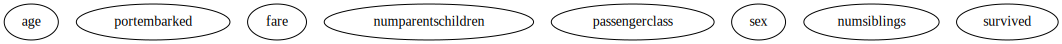

Starting Hill Climb algorithm, 8 variables detected
Initializing empty model.
[iter:0] Computing neighbors.
[iter:0] Computing scores
[iter:0] Best score: 4140.11945447151


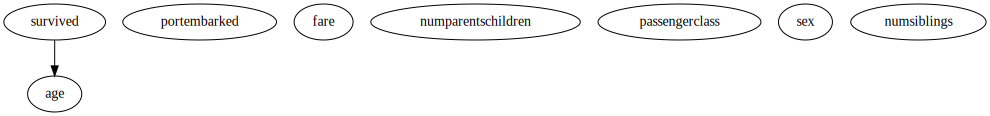

[iter:1] Computing neighbors.
[iter:1] Computing scores
[iter:1] Best score: 4147.829684649915


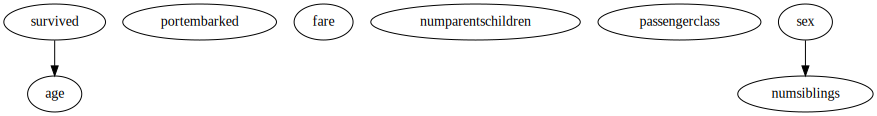

[iter:2] Computing neighbors.
[iter:2] Computing scores
[iter:2] Best score: 4154.615732914551


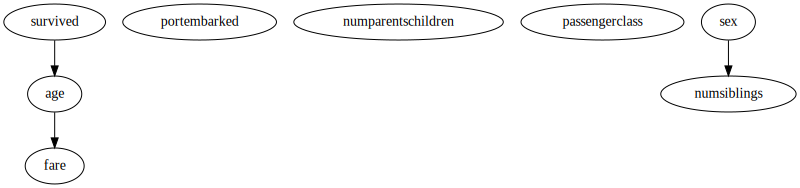

[iter:3] Computing neighbors.
[iter:3] Computing scores
[iter:3] Best score: 4160.483489783423


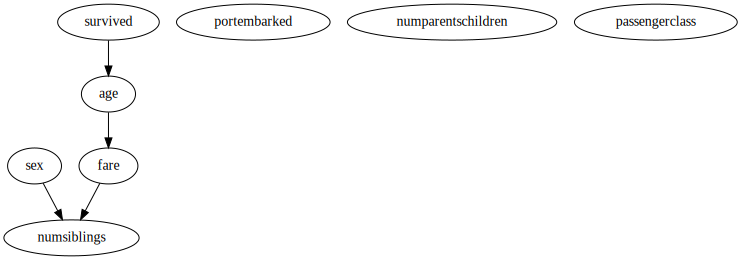

[iter:4] Computing neighbors.
[iter:4] Computing scores
[iter:4] Best score: 4165.797884846891


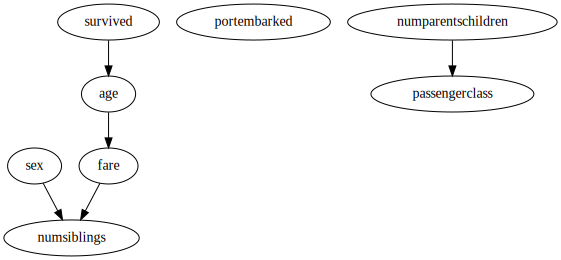

[iter:5] Computing neighbors.
[iter:5] Computing scores
[iter:5] Best score: 4170.00558221981


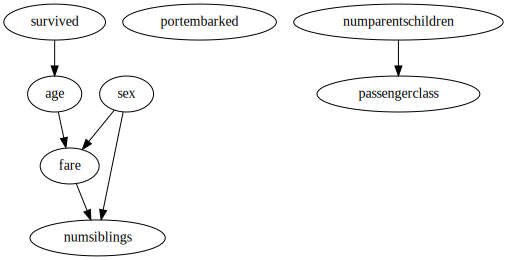

[iter:6] Computing neighbors.
[iter:6] Computing scores
[iter:6] Best score: 4174.007721986239


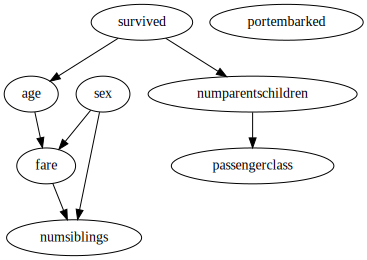

[iter:7] Computing neighbors.
[iter:7] Computing scores
[iter:7] Best score: 4177.215764115232


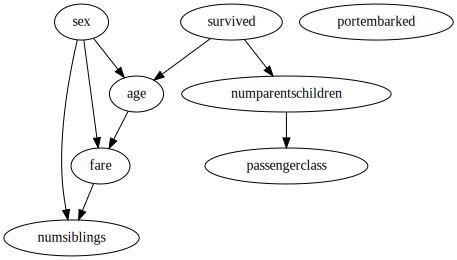

[iter:8] Computing neighbors.
[iter:8] Computing scores
[iter:8] Best score: 4179.543204283258


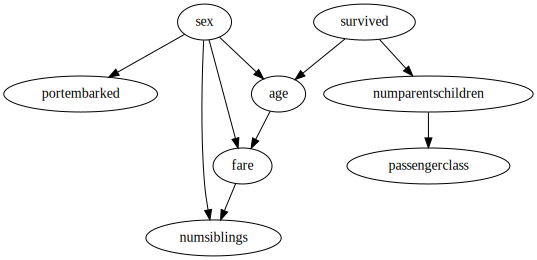

[iter:9] Computing neighbors.
[iter:9] Computing scores
[iter:9] Best score: 4181.510764175816


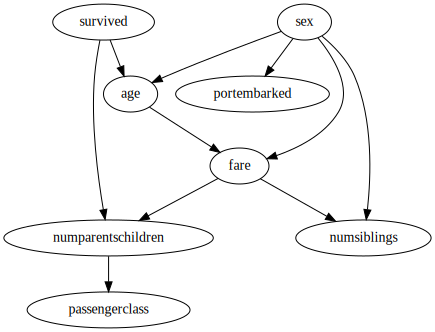

[iter:10] Computing neighbors.
[iter:10] Computing scores
[iter:10] Best score: 4181.510764175816


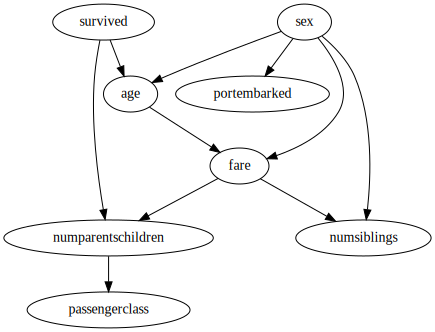

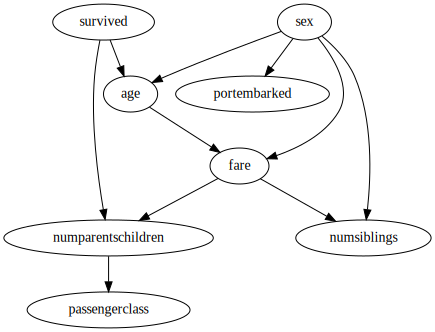

Hill Climb took 17.702s and 11 iterations.


{'age': {'fare'}, 'portembarked': set(), 'fare': {'numparentschildren', 'numsiblings'}, 'numparentschildren': {'passengerclass'}, 'passengerclass': set(), 'sex': {'fare', 'numsiblings', 'portembarked', 'age'}, 'numsiblings': set(), 'survived': {'numparentschildren', 'age'}}

In [7]:
url = "https://web.stanford.edu/class/aa228/projects/small.csv"
s = requests.get(url).content
data1 = pandas.read_csv(io.StringIO(s.decode('utf-8')))

hc = HillClimbing()
model1 = hc.search(data1, save=True)
model1

#### B) Wine - Medium example (12 variables, ~1m 46s)

This data set provides information related to red and white variants of the Portuguese "Vinho Verde" wine \[[4](#References)\].

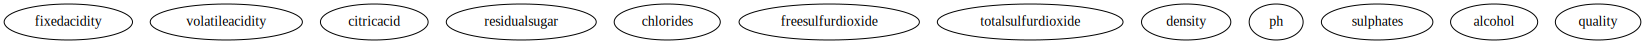

Starting Hill Climb algorithm, 12 variables detected
Initializing empty model.
[iter:0] Computing neighbors.
[iter:0] Computing scores
[iter:0] Best score: 45199.21031277844


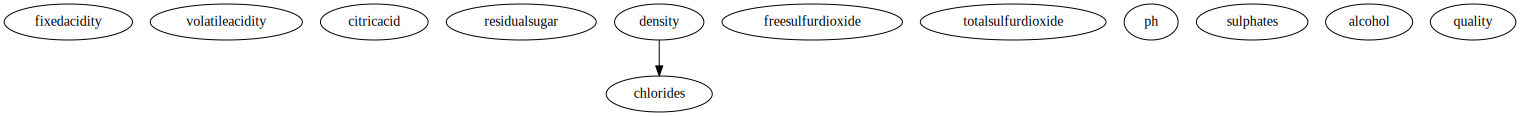

[iter:1] Computing neighbors.
[iter:1] Computing scores
[iter:1] Best score: 45212.03123458239


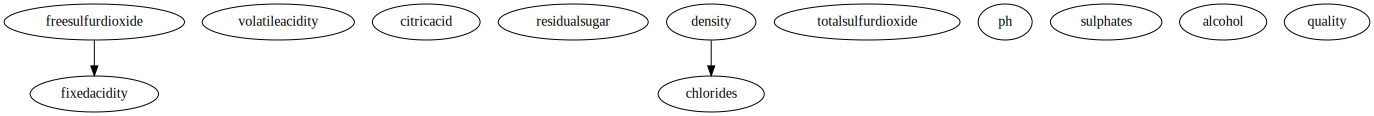

[iter:2] Computing neighbors.
[iter:2] Computing scores
[iter:2] Best score: 45224.79263801195


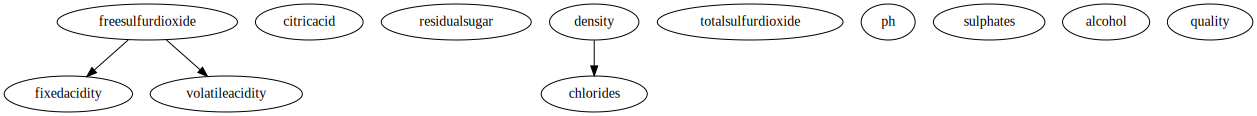

[iter:3] Computing neighbors.
[iter:3] Computing scores
[iter:3] Best score: 45237.25739440934


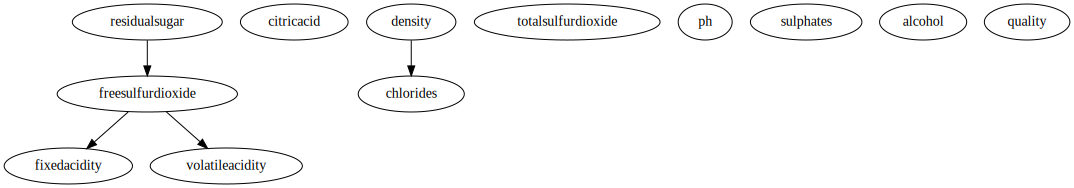

[iter:4] Computing neighbors.
[iter:4] Computing scores
[iter:4] Best score: 45248.22322470058


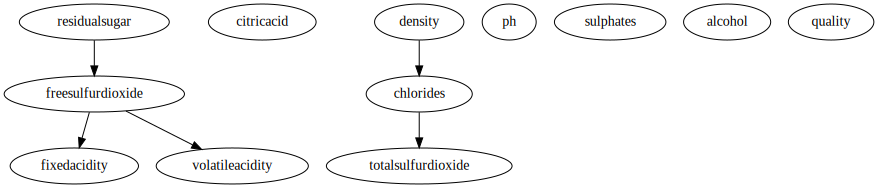

[iter:5] Computing neighbors.
[iter:5] Computing scores
[iter:5] Best score: 45257.76033217959


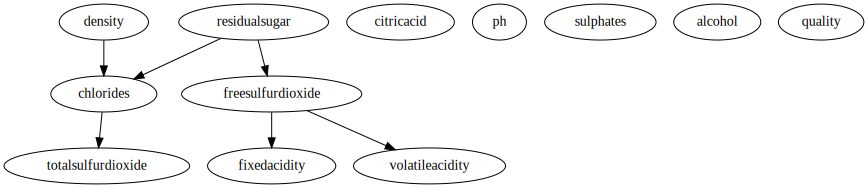

[iter:6] Computing neighbors.
[iter:6] Computing scores
[iter:6] Best score: 45266.26737830093


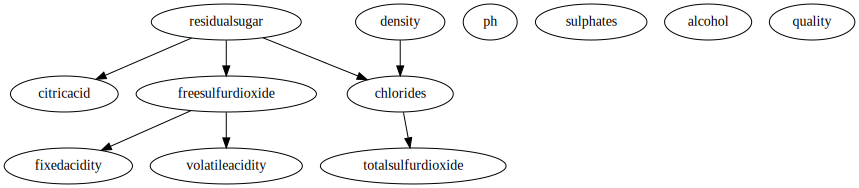

[iter:7] Computing neighbors.
[iter:7] Computing scores
[iter:7] Best score: 45273.26412365307


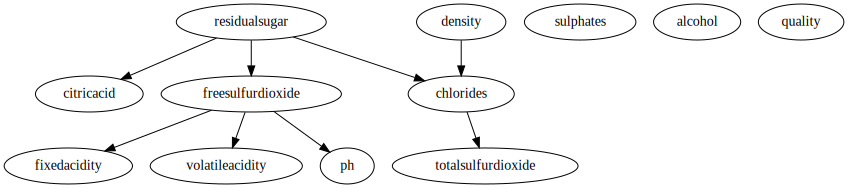

[iter:8] Computing neighbors.
[iter:8] Computing scores
[iter:8] Best score: 45279.48084830653


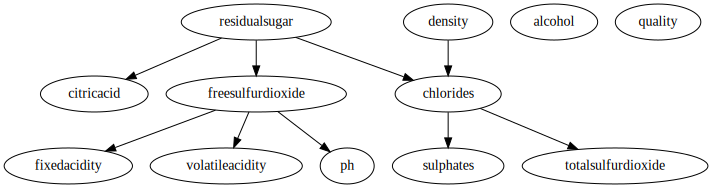

[iter:9] Computing neighbors.
[iter:9] Computing scores
[iter:9] Best score: 45283.29954994079


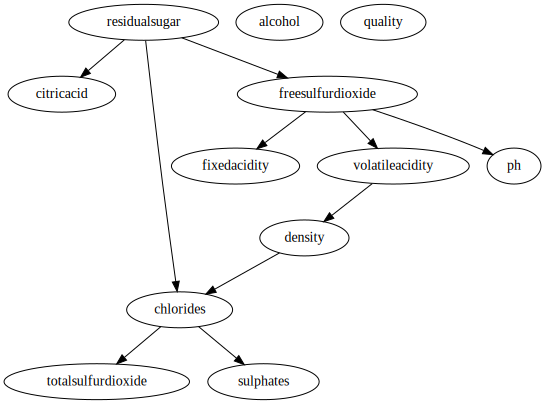

[iter:10] Computing neighbors.
[iter:10] Computing scores
[iter:10] Best score: 45285.4323541615


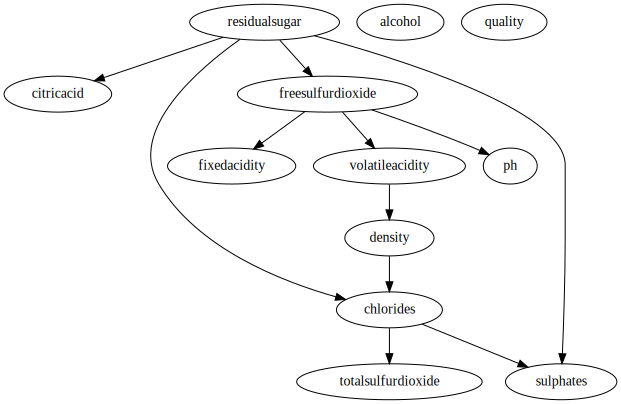

[iter:11] Computing neighbors.
[iter:11] Computing scores
[iter:11] Best score: 45286.41167347247


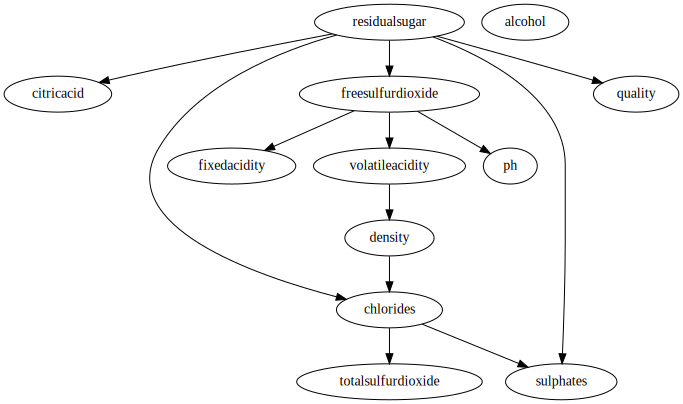

[iter:12] Computing neighbors.
[iter:12] Computing scores
[iter:12] Best score: 45286.41573864737


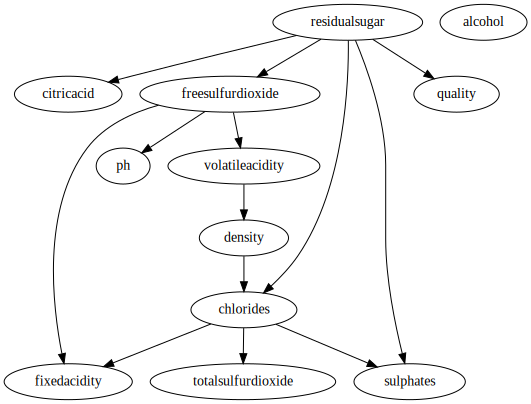

[iter:13] Computing neighbors.
[iter:13] Computing scores
[iter:13] Best score: 45286.41573864737


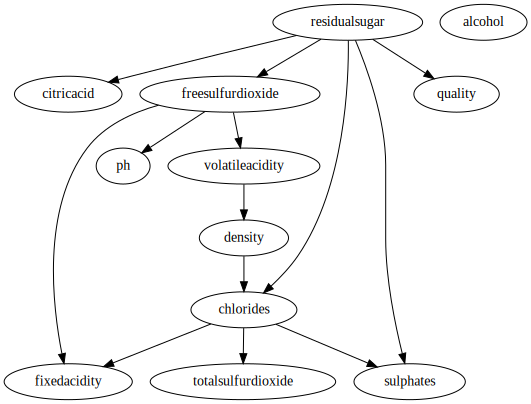

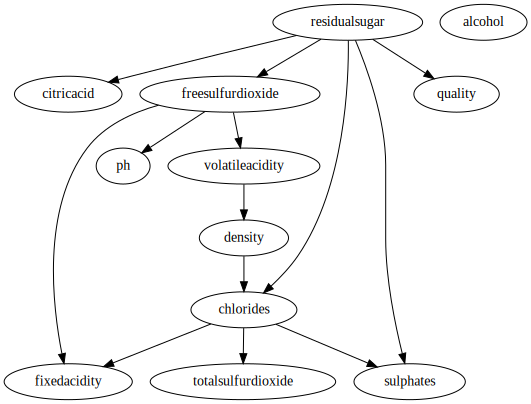

Hill Climb took 121.623s and 14 iterations.


{'fixedacidity': set(), 'volatileacidity': {'density'}, 'citricacid': set(), 'residualsugar': {'sulphates', 'freesulfurdioxide', 'chlorides', 'quality', 'citricacid'}, 'chlorides': {'sulphates', 'fixedacidity', 'totalsulfurdioxide'}, 'freesulfurdioxide': {'ph', 'fixedacidity', 'volatileacidity'}, 'totalsulfurdioxide': set(), 'density': {'chlorides'}, 'ph': set(), 'sulphates': set(), 'alcohol': set(), 'quality': set()}

In [8]:
url = "https://web.stanford.edu/class/aa228/projects/medium.csv"
s = requests.get(url).content
data2 = pandas.read_csv(io.StringIO(s.decode('utf-8')))

hc = HillClimbing()
model2 = hc.search(data2, save=True)
model2

#### C) Insane example (Caution: 50 variables, 81 iter. in ~4 hours and did not converge)
Despite of being tedious, it is possible to see fancy results in the README of the repository [here](https://bitbucket.org/davidr3v1/mlnn-project-1/src/master/README.md).

In [ ]:
url = "https://web.stanford.edu/class/aa228/projects/large.csv"
s = requests.get(url).content
data3 = pandas.read_csv(io.StringIO(s.decode('utf-8')))

hc = HillClimbing()
model3 = hc.search(data3, save=True)
model3

## Parameter Learning
Once we have the model structure, we need to learn probabilities along variables, so the next module estimates the the conditional probability distribution table (CPD) of the data and model.

**Caution: When plotting CPD table's, headers are badly formatted, they should extend until the end.**

In [9]:
class ParameterEstimation:
    def __init__(self, model, data):
        """
        Parameter estimation por model variables
        """
        assert type(data) == pandas.DataFrame, "Dataset is not a pandas DataFrame"
        assert isinstance(model, Model), "Model is not a model object"

        # Pandas dataframe
        self.data = data

        self.epsilon = 0

        self.model = model
        self._occurrences = {}
        self.cpd = {}
        self._proba = {}
        self._proba_cond = {}
        self._times_in_ds = {}

    def _times_in_dataset(self, x, val, pa, pa_values):
        """
        Counts the number of times the combinations (x=val, pa=pa_values)
        appears in the dataset.

        Parameters
        ---------
        x: str
            Variable name in dataset
        val: int, float
            Variable value
        pa: tuple
            Parent's names in dataset
        pa_values: list
            Parent's values

        Returns
        -------
        int
            Occurrences of given combination

        References
        ---------
        - Pandas Query, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html
        """
        query = f"{x} == {val} and "
        query += " and ".join([f"{pa[i]} == {pa_values[i]}" for i in range(len(pa))])

        if query not in self._times_in_ds:
            queried = self.data.query(query)
            self._times_in_ds[query] = len(queried)

        return self._times_in_ds[query]

    def estimate_cpd(self, node, show=True):
        """
        Estimate the CPD for a given variable.

        Parameters
        ----------
        node: int, string
            The name of the variable for which the CPD is to be estimated.
        show: bool
            Plot CPD table

        Returns
        -------
        dict
        """

        if node not in self.cpd:
            pa = tuple(self.model.parents[node])
            x_values = self.model.node_configurations(node, self.data)
            self.cpd[node] = {x_value: {} for x_value in x_values}

            if pa:
                pa_values = self.model.parents_configurations(pa, self.data)
                for x_value in x_values:
                    for pa_value in pa_values:
                        occurences = self._times_in_dataset(node, x_value, pa, pa_value)

                        zipped_pa = tuple(zip(pa, pa_value))
                        query = " and ".join([f"{pa_x} == {pa_v}" for (pa_x, pa_v) in zipped_pa])
                        if occurences:
                            if (node, x_value, query) not in self._proba_cond:
                                self._proba_cond[(node, x_value, query)] = proba_cond(node, x_value,
                                                                                            zipped_pa, self.data)
                        else:
                            self._proba_cond[(node, x_value, query)] = 0

                        # Add to CPD
                        self.cpd[node][x_value][zipped_pa] = self._proba_cond[(node, x_value, query)]

            else:
                for x_value in x_values:
                    if (node, x_value) not in self._occurrences:
                        self._occurrences[(node, x_value)] = self.data[node].value_counts()[x_value]

                    if self._occurrences[(node, x_value)] and (node, x_value) not in self._proba:
                        self._proba[(node, x_value)] = proba(node, x_value, self.data)
                    else:
                        self._proba[(node, x_value)] = 0

                    # Add to CPD
                    self.cpd[node][x_value] = self._proba[(node, x_value)]

        if show:
            self.show_table(node)

        return self.cpd[node]

    def show_table(self, node):
        # FIXME: Table headers are bad formatted
        parents = tuple(self.model.parents[node])
        table = []
        cell_len = 10
        if parents:
            cell_len *= len(parents)
            row = 1
            for parent in parents[::-1]:
                parent_states = sorted(numpy.unique(self.data[parent].values))
                h = ""
                for _ in range(row):
                    for state in map(str, parent_states):
                        h += f"{state:^{cell_len - 1}}|"
                table.append(f'| {parent:^15.13} |{h}')

                cell_len = cell_len // len(parents)
                row += 1

            cell_len = 10
            table.append(f'| {node:^15.13} |')

            for key in self.cpd[node].keys():
                dictionary = list(self.cpd[node][key].items())
                items = [(tuple(map(lambda x: x[1], d[0])), d[1]) for d in dictionary]
                items.sort(key=lambda x: x[0])

                probs = list(map(str, [round(item[1], 5) for item in items]))
                r = ""
                for prob in probs:
                    r += f"{prob:^{cell_len - 1}}|"
                table.append(f'| {str(key):^15} |{r}')

        else:
            table.append(f'| {node:^15.13}')
            items = list(self.cpd[node].items())
            items.sort(key=lambda x: x[0])
            for (key, prob) in items:
                prob = round(prob, 5)
                r = f"{prob:^{cell_len - 1}}|"
                table.append(f'| {key:^15} |{r}')

        print("\n".join(table), end="\n\n")

    def parameters(self, show=True):
        """
        Returns model parameters

        Parameters
        ----------
        show: bool
            Plot CPD table

        Returns
        -------
        dict
        """
        parameters = {node: self.estimate_cpd(node, show=show) for node in self.model.nodes}

        return parameters


#### A) Titanic - Small example (8 variables, ~15s)

Titanic parameters

In [9]:
pe1 = ParameterEstimation(model1, data1)
pe1.parameters(show=True)

|    survived     |         1         |         2         |
|       sex       |    1    |    2    |    1    |    2    |
|       age       |
|        2        | 0.6047  | 0.59633 | 0.53086 | 0.56277 |
|        1        | 0.32479 | 0.36697 | 0.45679 | 0.38961 |
|        3        | 0.07051 | 0.0367  | 0.01235 | 0.04762 |

|       sex       |    1    |    2    |
|  portembarked   |
|        1        | 0.7643  | 0.65064 |
|        2        | 0.16464 | 0.23397 |
|        3        | 0.07106 | 0.11538 |

|       age       |         1         |         2         |         3         |
|       sex       |    1    |    2    |    1    |    2    |
|      fare       |
|        1        | 0.98958 | 0.98563 | 0.97297 | 0.95276 | 0.96532 |   1.0   |
|        2        | 0.01042 | 0.00862 | 0.02703 | 0.04724 | 0.0289  |    0    |
|        3        |    0    | 0.00575 |    0    |    0    | 0.00578 |    0    |

|      fare       |         1         |         2         |         3         |
|    survived    

{'age': {2: {(('sex', 1.0), ('survived', 1.0)): 0.6047008547008547,
   (('sex', 2.0), ('survived', 1.0)): 0.5308641975308642,
   (('sex', 1.0), ('survived', 2.0)): 0.5963302752293578,
   (('sex', 2.0), ('survived', 2.0)): 0.5627705627705628},
  1: {(('sex', 1.0), ('survived', 1.0)): 0.3247863247863248,
   (('sex', 2.0), ('survived', 1.0)): 0.4567901234567901,
   (('sex', 1.0), ('survived', 2.0)): 0.3669724770642202,
   (('sex', 2.0), ('survived', 2.0)): 0.38961038961038963},
  3: {(('sex', 1.0), ('survived', 1.0)): 0.07051282051282051,
   (('sex', 2.0), ('survived', 1.0)): 0.012345679012345678,
   (('sex', 1.0), ('survived', 2.0)): 0.03669724770642202,
   (('sex', 2.0), ('survived', 2.0)): 0.047619047619047616}},
 'portembarked': {1: {(('sex', 1.0),): 0.7642980935875217,
   (('sex', 2.0),): 0.6506410256410257},
  2: {(('sex', 1.0),): 0.16464471403812825,
   (('sex', 2.0),): 0.23397435897435898},
  3: {(('sex', 1.0),): 0.07105719237435008,
   (('sex', 2.0),): 0.11538461538461539}},
 'fa

#### B) Wine - Medium example (12 variables, ~1m 46s)

This data set provides information related to red and white variants of the Portuguese "Vinho Verde" wine \[[4](#References)\].

In [ ]:
pe2 = ParameterEstimation(model2, data2)
print(pe2.parameters(show=True))

## References
1. [Structure Learning of Probabilistic Graphical Models:  A Comprehensive Survey, Y. Zhou](https://arxiv.org/pdf/1111.6925.pdf)
2. [Titanic](https://cran.r-project.org/web/packages/titanic/titanic.pdf) dataset.
3. [Stanford](https://web.stanford.edu/class/aa228/projects/1/) project reference.
4. [Wine](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) dataset.